# Adaptation Measures

Adaptation measures are defined by parameters that alter the exposures, hazard or impact functions. Risk transfer options are also considered. Single measures are defined in the `Measure` class, which can be aggregated to a `MeasureSet`.

## Measure class

A measure is characterized by the following attributes:

Related to measure's description:
 * name (str): name of the action
 * haz_type (str): related hazard type (peril), e.g. TC
 * color_rgb (np.array): integer array of size 3. Gives color code of this measure in RGB
 * cost (float): discounted cost (in same units as assets). Needs to be provided by the user. See the example provided in `climada_python/climada/data/system/entity_template.xlsx` sheets `_measures_details` and `_discounting_sheet` to see how the discounting is done.
 
Related to a measure's impact:
 * hazard_set (str): file name of hazard to use
 * hazard_freq_cutoff (float): hazard frequency cutoff
 * exposure_set (str): file name of exposure to use
 * hazard_inten_imp (tuple): parameter a and b of hazard intensity change
 * mdd_impact (tuple): parameter a and b of the impact over the mean damage degree
 * paa_impact (tuple): parameter a and b of the impact over the percentage of affected assets
 * imp_fun_map (str): change of impact function id, e.g. '1to3'
 * exp_region_id (int): region id of the selected exposures to consider ALL the previous parameters
 * risk_transf_attach (float): risk transfer attachment. Applies to the whole exposure.
 * risk_transf_cover (float): risk transfer cover. Applies to the whole exposure.

Parameters description:

`hazard_set` and `exposures_set` provide the file names in h5 format (generated by CLIMADA) of the hazard and exposures to use as a result of the implementation of the measure. These might be further modified when applying the other parameters.

`hazard_inten_imp`, `mdd_impact` and `paa_impact` transform the impact functions linearly as follows: 
 
     intensity = intensity*hazard_inten_imp[0] + hazard_inten_imp[1]
     mdd = mdd*mdd_impact[0] + mdd_impact[1]
     paa = paa*paa_impact[0] + paa_impact[1]
     
`hazard_freq_cutoff` modifies the hazard by putting 0 intensities to the events whose impact exceedance frequency are greater than `hazard_freq_cutoff`.

`imp_fun_map` indicates the ids of the impact function to replace and its replacement. The `impf_XX` variable of `Exposures` with the affected impact function id will be correspondingly modified (`XX` refers to the `haz_type` of the measure).

`exp_region_id` will apply all the previous changes only to the `region_id` indicated. This means that only the exposures with that `region_id` and the hazard's centroids close to them will be modified with the previous changes, the other regions will remain unaffected to the measure.

`risk_transf_attach` and `risk_transf_cover` are the deductible and coverage of any event to happen.

Methods description:

The method `check()` validates the attibutes. `apply()` applies the measure to a given exposure, impact function and hazard, returning their modified values. The parameters related to insurability (risk_transf_attach and risk_transf_cover) affect the resulting impact and are therefore not applied in the `apply()` method yet. 

`calc_impact()` calls to `apply()`, applies the insurance parameters and returns the final impact and risk transfer of the measure. This method is called from the `CostBenefit` class.

The method `apply()` allows to visualize the effect of a measure. Here are some examples:

/Users/ckropf/opt/anaconda3/envs/climada_env/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


Text(0.5, 1.0, 'TC: Modified impact function')

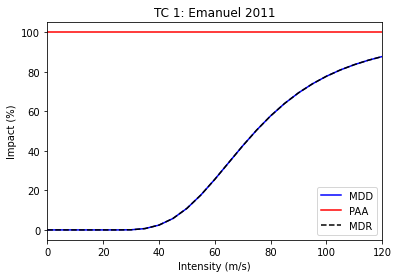

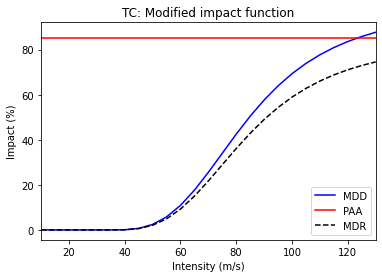

In [1]:
# effect of mdd_impact, paa_impact, hazard_inten_imp
%matplotlib inline
import numpy as np
from climada.entity import ImpactFuncSet, ImpfTropCyclone, Exposures
from climada.entity.measures import Measure
from climada.hazard import Hazard

# define measure
meas = Measure(
    name="Mangrove",
    haz_type="TC",
    color_rgb=np.array([1, 1, 1]),
    cost=500000000,
    mdd_impact=(1, 0),
    paa_impact=(1, -0.15),
    hazard_inten_imp=(1, -10),  # reduces intensity by 10
)

# impact functions
impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_all = ImpactFuncSet([impf_tc])
impf_all.plot()

# dummy Hazard and Exposures
haz = Hazard("TC")  # this measure does not change hazard
exp = Exposures()  # this measure does not change exposures

# new impact functions
new_exp, new_impfs, new_haz = meas.apply(exp, impf_all, haz)
axes = new_impfs.plot()
axes.set_title("TC: Modified impact function")

In [5]:
# effect of hazard_freq_cutoff
import numpy as np
from climada.entity import ImpactFuncSet, ImpfTropCyclone, Exposures
from climada.entity.measures import Measure
from climada.hazard import Hazard
from climada.engine import ImpactCalc

from climada.util import HAZ_DEMO_H5, EXP_DEMO_H5

# define measure
meas = Measure(
    name="Mangrove",
    haz_type="TC",
    color_rgb=np.array([1, 1, 1]),
    cost=500000000,
    hazard_freq_cutoff=0.0255,
)

# impact functions
impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_all = ImpactFuncSet([impf_tc])

# Hazard
haz = Hazard.from_hdf5(HAZ_DEMO_H5)
haz.check()

# Exposures
exp = Exposures.from_hdf5(EXP_DEMO_H5)
exp.check()

# new hazard
new_exp, new_impfs, new_haz = meas.apply(exp, impf_all, haz)
# if you look at the maximum intensity per centroid: new_haz does not contain the event with smaller impact (the most frequent)
haz.plot_intensity(0)
new_haz.plot_intensity(0)
# you might also compute the exceedance frequency curve of both hazard
imp = ImpactCalc(exp, impf_all, haz).impact()
ax = imp.calc_freq_curve().plot(label="original")

new_imp = ImpactCalc(new_exp, new_impfs, new_haz).impact()
new_imp.calc_freq_curve().plot(
    axis=ax, label="measure"
);  # the damages for events with return periods > 1/0.0255 ~ 40 are 0

2025-04-07 11:44:03,831 - climada.hazard.io - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5
2025-04-07 11:44:03,852 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5
2025-04-07 11:44:03,864 - climada.entity.exposures.base - INFO - centr_ not set.


/Users/ckropf/opt/anaconda3/envs/climada_env/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)


2025-04-07 11:43:34,318 - climada.hazard.io - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5
2025-04-07 11:43:34,331 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5
2025-04-07 11:43:34,339 - climada.entity.exposures.base - INFO - centr_ not set.


/Users/ckropf/opt/anaconda3/envs/climada_env/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)


2025-04-07 11:43:35,264 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2025-04-07 11:43:35,266 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-04-07 11:43:35,268 - climada.engine.impact_calc - INFO - Calculating impact for 250 assets (>0) and 216 events.
2025-04-07 11:43:35,269 - climada.engine.impact_calc - INFO - cover and/or deductible columns detected, going to calculate insured impact
2025-04-07 11:43:35,276 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2025-04-07 11:43:35,277 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-04-07 11:43:36,842 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2025-04-07 11:43:36,843 - climada.entity.exposures.base - INFO - Existing cent

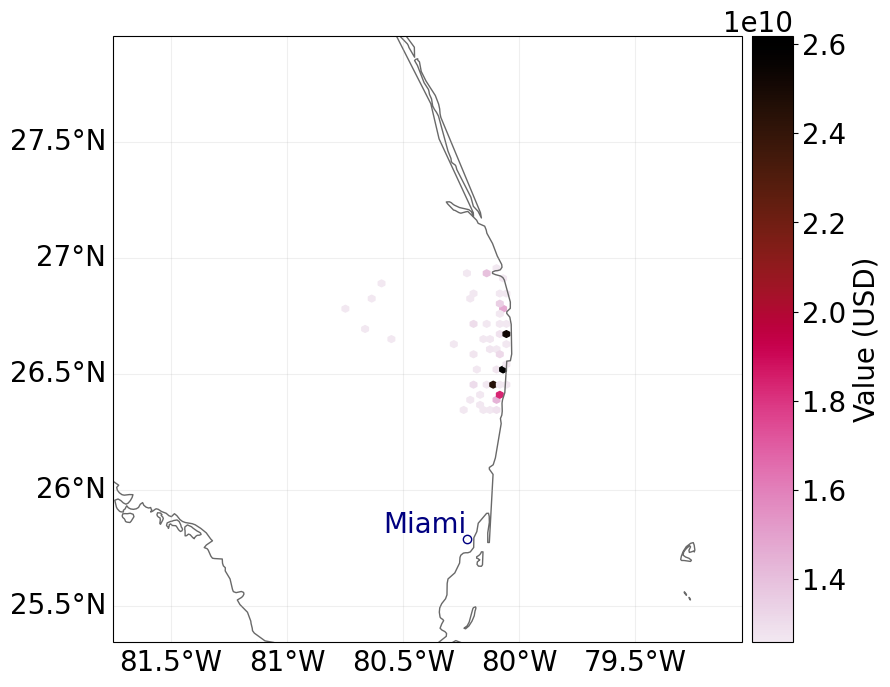

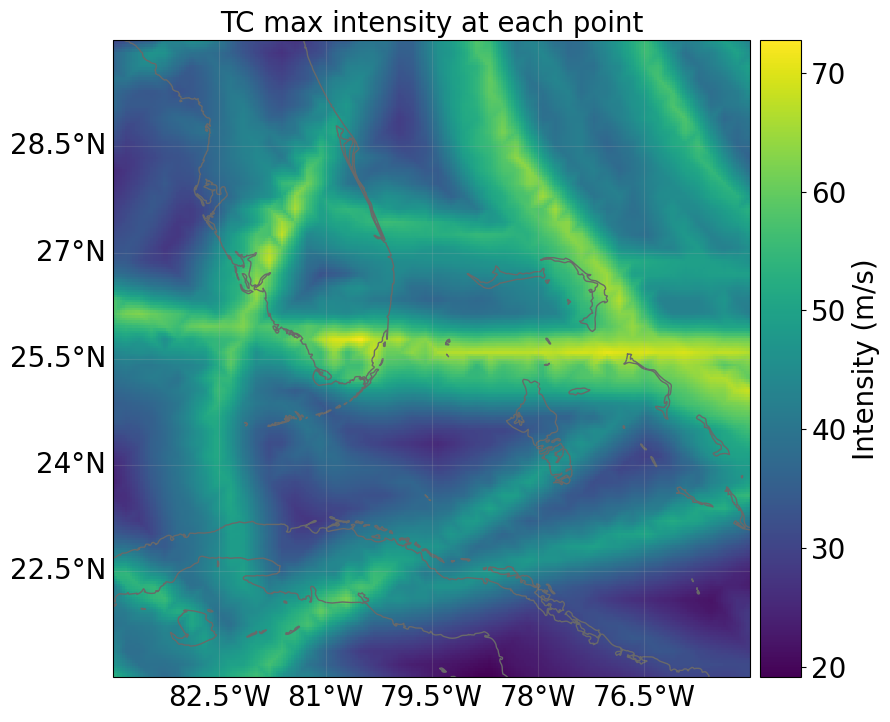

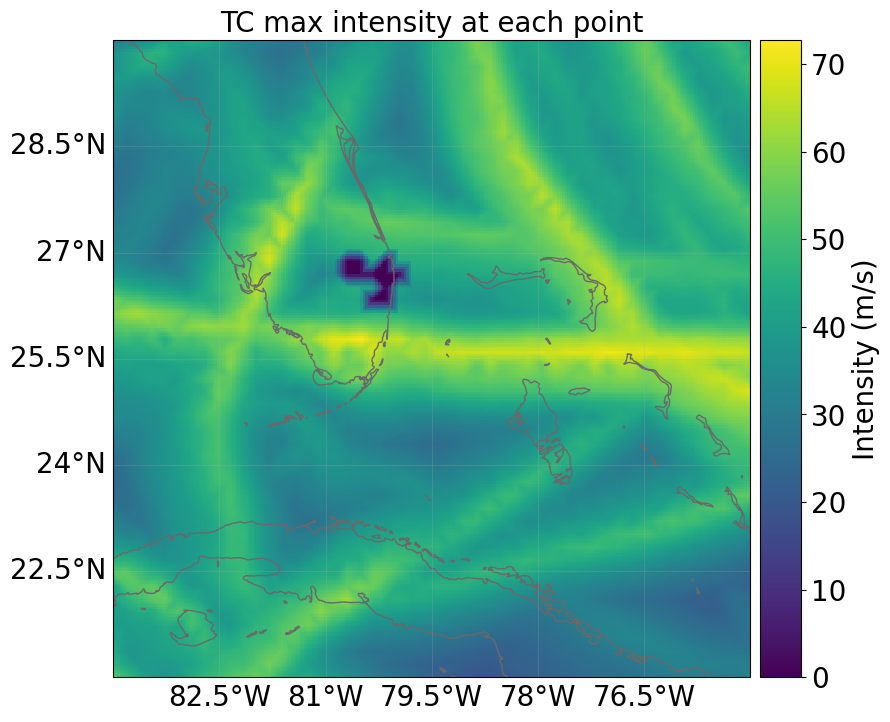

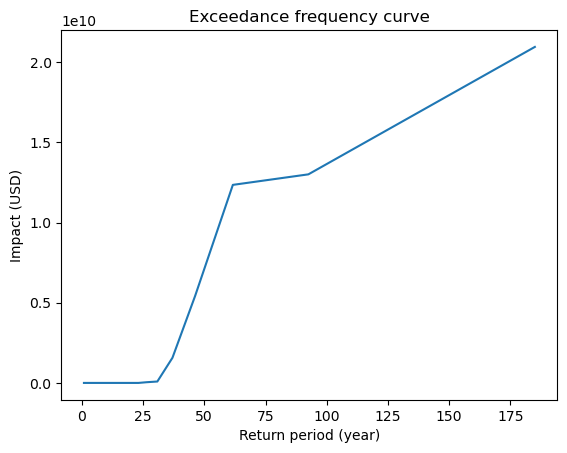

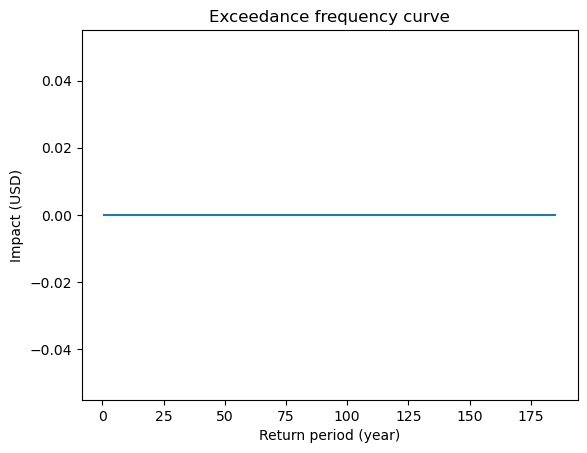

In [3]:
# effect of exp_region_id
import numpy as np
from climada.entity import ImpactFuncSet, ImpfTropCyclone, Exposures
from climada.entity.measures import Measure
from climada.hazard import Hazard
from climada.engine import ImpactCalc

from climada.util import HAZ_DEMO_H5, EXP_DEMO_H5

# define measure
meas = Measure(
    name="Building code",
    haz_type="TC",
    color_rgb=np.array([1, 1, 1]),
    cost=500000000,
    hazard_freq_cutoff=0.00455,
    exp_region_id=[1],  # apply measure to points close to exposures with region_id=1
)

# impact functions
impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_all = ImpactFuncSet([impf_tc])

# Hazard
haz = Hazard.from_hdf5(HAZ_DEMO_H5)
haz.check()

# Exposures
exp = Exposures.from_hdf5(EXP_DEMO_H5)
# exp['region_id'] = np.ones(exp.shape[0])
exp.check()
# all exposures have region_id=1
exp.plot_hexbin(buffer=1.0)

# new hazard
new_exp, new_impfs, new_haz = meas.apply(exp, impf_all, haz)
# the cutoff has been apllied only in the region of the exposures
haz.plot_intensity(0)
new_haz.plot_intensity(0)

# the exceddance frequency has only been computed for the selected exposures before doing the cutoff.
# since we have removed the hazard of the places with exposure, the new exceedance frequency curve is zero.
imp = ImpactCalc(exp, impf_all, haz).impact()
imp.calc_freq_curve().plot()

new_imp = ImpactCalc(new_exp, new_impfs, new_haz).impact()
new_imp.calc_freq_curve().plot();

2025-04-07 11:45:09,502 - climada.hazard.io - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5
2025-04-07 11:45:09,527 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5
2025-04-07 11:45:09,539 - climada.entity.exposures.base - INFO - centr_ not set.
2025-04-07 11:45:09,541 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2025-04-07 11:45:09,543 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-04-07 11:45:09,546 - climada.engine.impact_calc - INFO - Calculating impact for 250 assets (>0) and 216 events.
2025-04-07 11:45:09,546 - climada.engine.impact_calc - INFO - cover and/or deductible columns detected, going to calculate insured impact
2025-04-07 11:45:09,555 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2025-04-07 11:45:09,556 - climada.enti

/Users/ckropf/opt/anaconda3/envs/climada_env/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)


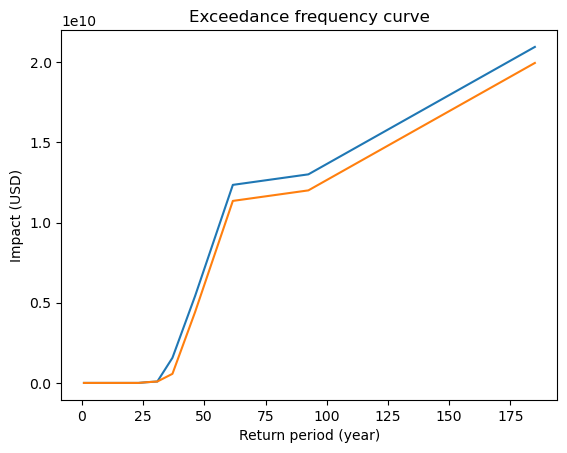

In [6]:
# effect of risk_transf_attach and risk_transf_cover
import numpy as np
from climada.entity import ImpactFuncSet, ImpfTropCyclone, Exposures
from climada.entity.measures import Measure
from climada.hazard import Hazard
from climada.engine import ImpactCalc

from climada.util import HAZ_DEMO_H5, EXP_DEMO_H5

# define measure
meas = Measure(
    name="Insurance",
    haz_type="TC",
    color_rgb=np.array([1, 1, 1]),
    cost=500000000,
    risk_transf_attach=5.0e8,
    risk_transf_cover=1.0e9,
)

# impact functions
impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_all = ImpactFuncSet([impf_tc])

# Hazard
haz = Hazard.from_hdf5(HAZ_DEMO_H5)
haz.check()

# Exposures
exp = Exposures.from_hdf5(EXP_DEMO_H5)
exp.check()

# impact before
imp = ImpactCalc(exp, impf_all, haz).impact()
ax = imp.calc_freq_curve().plot(label="original")

# impact after. risk_transf will be added to the cost of the measure
imp_new, risk_transf = meas.calc_impact(exp, impf_all, haz)
imp_new.calc_freq_curve().plot(axis=ax, label="measure")
print("risk_transfer {:.3}".format(risk_transf.aai_agg))

## MeasureSet class

Similarly to the `ImpactFuncSet`, `MeasureSet` is a container which handles `Measure` instances through the methods `append()`, `extend()`, `remove_measure()`and `get_measure()`. Use the `check()` method to make sure all the measures have been properly set. 

For a complete class documentation, refer to the Python modules docs: {py:class}`climada.entity.measures.measure_set.MeasureSet`

In [7]:
# build measures
import numpy as np
import matplotlib.pyplot as plt
from climada.entity.measures import Measure, MeasureSet

meas_1 = Measure(
    haz_type="TC",
    name="Mangrove",
    color_rgb=np.array([1, 1, 1]),
    cost=500000000,
    mdd_impact=(1, 2),
    paa_impact=(1, 2),
    hazard_inten_imp=(1, 2),
    risk_transf_cover=500,
)

meas_2 = Measure(
    haz_type="TC",
    name="Sandbags",
    color_rgb=np.array([1, 1, 1]),
    cost=22000000,
    mdd_impact=(1, 2),
    paa_impact=(1, 3),
    hazard_inten_imp=(1, 2),
    exp_region_id=2,
)

# gather all measures
meas_set = MeasureSet()
meas_set.append(meas_1)
meas_set.append(meas_2)
meas_set.check()

# select one measure
meas_sel = meas_set.get_measure(name="Sandbags")
print(meas_sel[0].name, meas_sel[0].cost)

Sandbags 22000000


## Read/write and measure sets to/from an Excel file

Measures defined in an excel file following the template provided in sheet `measures` of `climada_python/data/system/entity_template.xlsx` can be read directly using the method `from_excel()`. Measure sets can be written to file with the method `write_excel()`

In [3]:
from climada.entity.measures import MeasureSet
from climada.util import ENT_TEMPLATE_XLS  # import path of template file

# Fill DataFrame from Excel file
file_name = ENT_TEMPLATE_XLS  # provide absolute path of the excel file
meas_set = MeasureSet.from_excel(file_name)